In [1]:
import os
import sys

sys.path.insert(0, os.path.relpath("../../../../.."))

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import (
    SuperSimulationFactory,
)
from recidiviz.calculator.modeling.population_projection.transition_table import (
    TransitionTable,
)
from recidiviz.calculator.modeling.population_projection.shell_compartment import (
    ShellCompartment,
)
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from functools import partial
import yaml

In [2]:
%run ../../../../../../recidiviz-research/utils/research_utils.py

In [3]:
adjust_plot_scale(0.4)

In [4]:
policy_sim = SuperSimulationFactory.build_super_simulation(
    "../state/AZ/drug_possession_defelonization/AZ_drug_possession_defelonization.yaml"
)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 93.44rows/s]


In [5]:
# Simulate policy starting in Jan 2023
policy_ts = 4

new_probation_transition_df = pd.DataFrame(
    {
        "compartment": "probation",
        "outflow_to": "release_full",
        "compartment_duration": 1,
        "total_population": 1,
    },
    index=[0],
)

# Policy functions

remove_drug_trafficking_outflows = partial(
    ShellCompartment.reallocate_outflow,
    reallocation_fraction=1,
    outflow="prison",
    new_outflow="probation",
)

resentence_policy = partial(
    TransitionTable.use_alternate_transitions_data,
    alternate_historical_transitions=new_probation_transition_df,
    retroactive=False,
)

policy_list = [
    SparkPolicy(
        policy_fn=remove_drug_trafficking_outflows,
        spark_compartment="pretrial",
        sub_population={"crime_type": "x"},
        policy_ts=policy_ts,
        apply_retroactive=False,
    ),
    SparkPolicy(
        policy_fn=resentence_policy,
        spark_compartment="probation",
        sub_population={"crime_type": "x"},
        policy_ts=policy_ts,
        apply_retroactive=True,
    ),
]

/Users/justine/.local/share/virtualenvs/pulse-data-Biv6la68/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/justine/.local/share/virtualenvs/pulse-data-Biv6la68/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/justine/.local/share/virtualenvs/pulse-data-Biv6la68/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


initialization time:  0.2552509307861328
initialization time:  0.19928193092346191
simulation_time:  0.14503192901611328
simulation_time:  0.1395120620727539
3829.011877622864


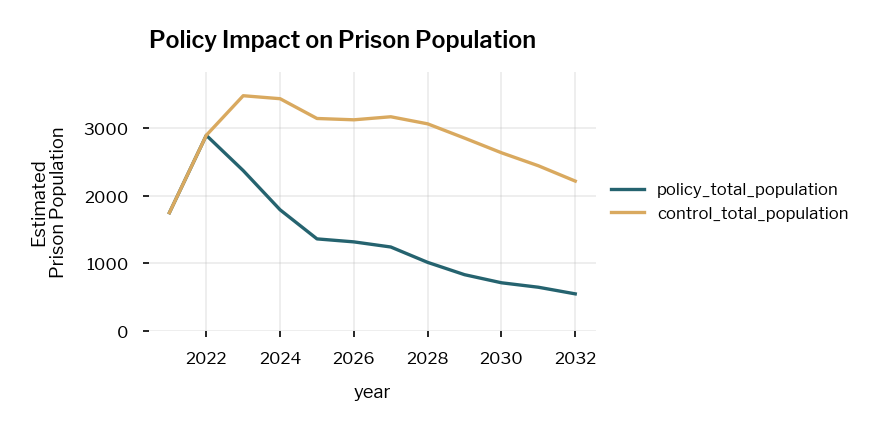

In [7]:
# Run the simulation
policy_results = policy_sim.simulate_policy(policy_list, "prison")
add_legend()

# Set all the output variables for the future plots (save yourself from plotting stale data)
baseline_outflows = (
    policy_sim.validator.pop_simulations["control"].get_outflows().copy()
)
baseline_outflows[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    baseline_outflows.index.get_level_values("time_step")
)
baseline_outflows = baseline_outflows[
    baseline_outflows["compartment"] != "release_full"
]

policy_outflows = policy_sim.validator.pop_simulations["policy"].get_outflows().copy()
policy_outflows[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    policy_outflows.index.get_level_values("time_step")
)
policy_outflows = policy_outflows[policy_outflows["compartment"] != "release_full"]

data_inputs = policy_sim.initializer.get_data_inputs()
outflows = data_inputs.outflows_data

<Figure size 576x336 with 0 Axes>

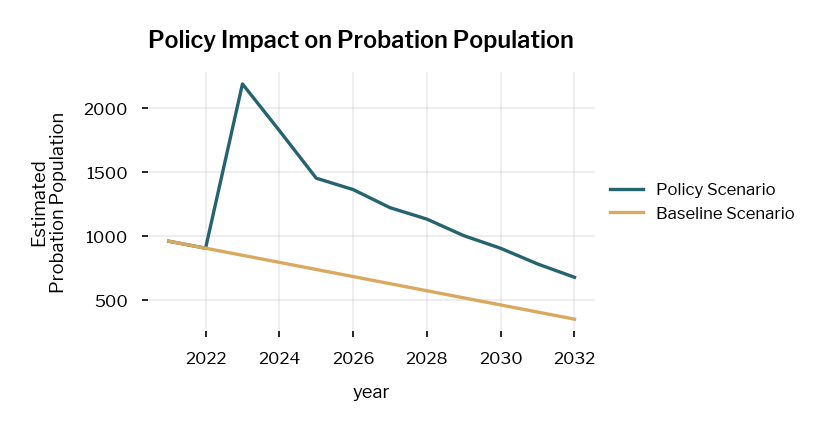

In [8]:
compartment = "probation"
plt.figure()
total_population = data_inputs.total_population_data.copy()
total_population[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    total_population["time_step"]
)
# ax = total_population[total_population["compartment"] == compartment
#                      ].plot(x="year", y="total_population",
#                             label="Historical Population")
policy_results[policy_results["compartment"] == compartment].plot(
    y=["policy_total_population", "control_total_population"],
    label=["Policy Scenario", "Baseline Scenario"],
)
plt.ylabel(f"Estimated\n{compartment.title()} Population")
plt.title(f"Policy Impact on {compartment.title()} Population")
add_legend()

<Figure size 576x336 with 0 Axes>

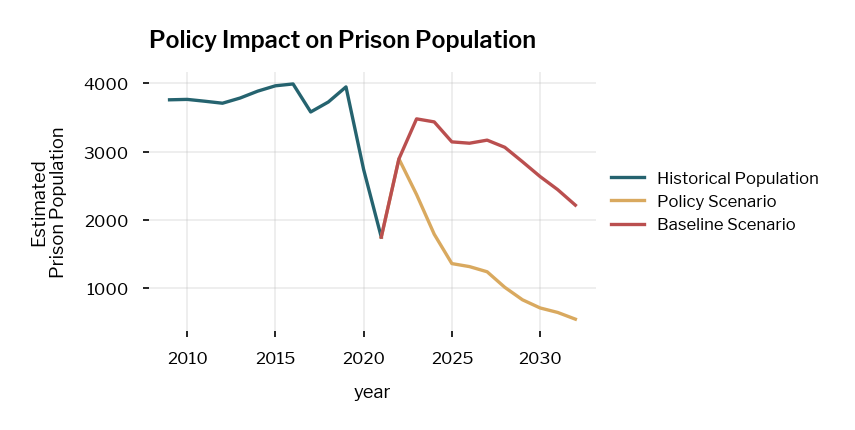

In [9]:
compartment = "prison"
plt.figure()
total_population = data_inputs.total_population_data.copy()
total_population[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    total_population["time_step"]
)
ax = (
    total_population[total_population["compartment"] == compartment]
    .sort_values(by="year")
    .plot(x="year", y="total_population", label="Historical Population")
)
policy_results[policy_results["compartment"] == compartment].plot(
    y=["policy_total_population", "control_total_population"],
    label=["Policy Scenario", "Baseline Scenario"],
    ax=ax,
)
plt.ylabel(f"Estimated\n{compartment.title()} Population")
plt.title(f"Policy Impact on {compartment.title()} Population")
add_legend()

<Figure size 576x336 with 0 Axes>

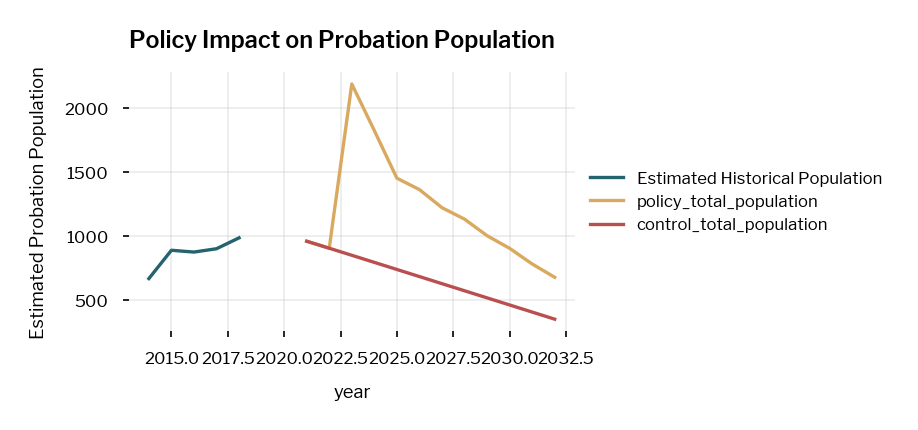

In [10]:
compartment = "probation"
plt.figure()
total_population = data_inputs.total_population_data.copy()
total_population[
    "year"
] = policy_sim.initializer.time_converter.convert_time_steps_to_year(
    total_population["time_step"]
)
ax = total_population[total_population["compartment"] == compartment].plot(
    x="year", y="total_population", label="Estimated Historical Population"
)
policy_results[policy_results["compartment"] == compartment].plot(
    y=["policy_total_population", "control_total_population"], ax=ax
)
plt.ylabel("Estimated Probation Population")
plt.title("Policy Impact on Probation Population")
add_legend()

In [181]:
simulation_tag = "AZ_drug_defelonization"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Text(0.0, 1.0, 'Baseline Simulation Projected Transitions')

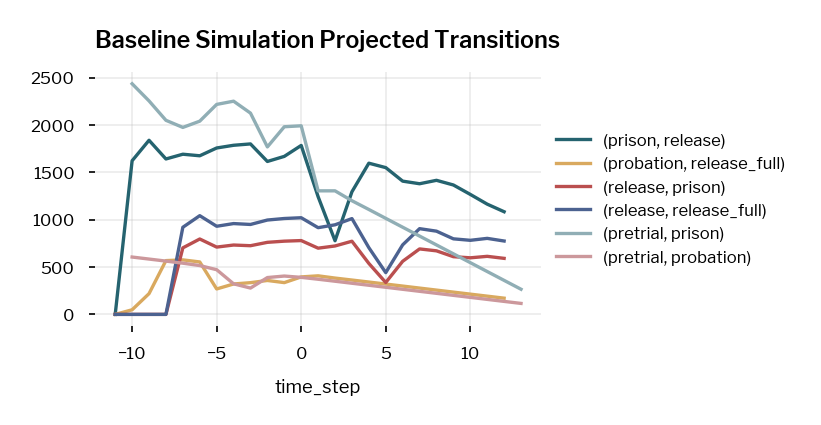

In [216]:
baseline_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Baseline Simulation Projected Transitions")

Text(0.0, 1.0, 'Policy Simulation Projected Transitions')

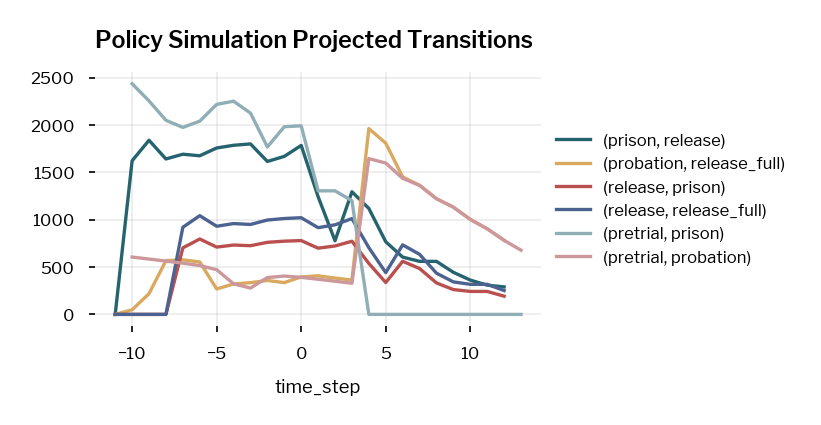

In [12]:
policy_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Policy Simulation Projected Transitions")

In [223]:
outflows_diff = baseline_outflows.reset_index(drop=False).merge(
    policy_outflows.reset_index(drop=False),
    how="inner",
    on=["time_step", "outflow_to", "compartment", "simulation_group", "year"],
    suffixes=("_control", "_policy"),
)
outflows_diff["outflows_difference"] = (
    outflows_diff["total_population_policy"] - outflows_diff["total_population_control"]
)
outflows_diff["actual_year"] = np.floor(outflows_diff["year"])
outflows_diff[
    (outflows_diff["outflow_to"] == "prison") & (outflows_diff["year"] >= 2022)
]

,outflow_to,time_step,total_population_control,compartment,simulation_group,year,total_population_policy,outflows_difference,actual_year
13,prison,3,1200.461063,pretrial,x,2022.0,1200.461063,0.000000,2022.0
14,prison,4,1108.130228,pretrial,x,2023.0,0.000000,-1108.130228,2023.0
15,prison,5,1014.373726,pretrial,x,2024.0,0.000000,-1014.373726,2024.0
16,prison,6,920.783714,pretrial,x,2025.0,0.000000,-920.783714,2025.0
17,prison,7,827.174259,pretrial,x,2026.0,0.000000,-827.174259,2026.0
18,prison,8,733.567075,pretrial,x,2027.0,0.000000,-733.567075,2027.0
19,prison,9,639.959625,pretrial,x,2028.0,0.000000,-639.959625,2028.0
20,prison,10,546.352207,pretrial,x,2029.0,0.000000,-546.352207,2029.0
21,prison,11,452.744784,pretrial,x,2030.0,0.000000,-452.744784,2030.0
22,prison,12,359.137362,pretrial,x,2031.0,0.000000,-359.137362,2031.0


<AxesSubplot:xlabel='year'>

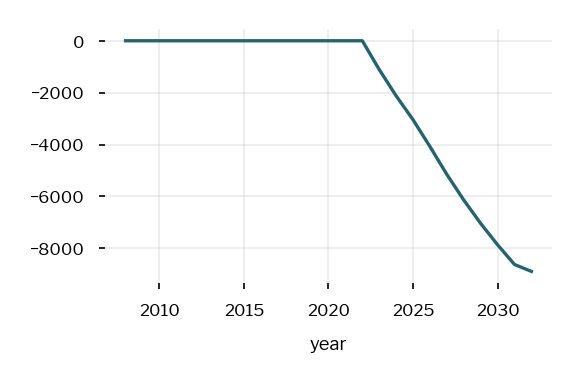

In [219]:
cummulative_outflows_diff = (
    outflows_diff.groupby(["outflow_to", "year"])
    .sum()
    .loc["prison", "outflows_difference"]
    .cumsum()
)
cummulative_outflows_diff.plot()

In [222]:
cummulative_outflows_diff[
    cummulative_outflows_diff.index.get_level_values("year") > 2022
]

year
2023.0   -1108.130228
2024.0   -2122.503955
2025.0   -3043.287669
2026.0   -4077.542284
2027.0   -5150.195462
2028.0   -6137.632825
2029.0   -7038.934828
2030.0   -7862.463371
2031.0   -8621.118126
2032.0   -8886.648067
Name: outflows_difference, dtype: float64

initialization time:  0.707988977432251
simulation_time:  0.46327805519104004


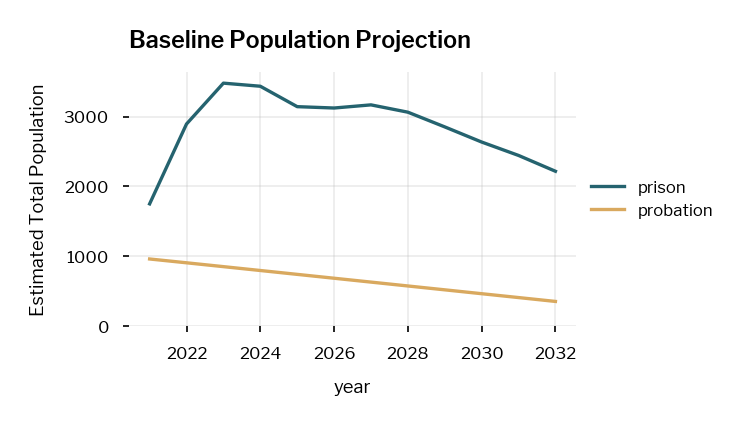

In [163]:
policy_sim.simulate_baseline(["prison", "probation"])
add_legend()

In [187]:
baseline_projection = policy_sim.get_population_simulations()[
    "control"
].get_population_projections()
baseline_outflows = policy_sim.get_population_simulations()["control"].get_outflows()
data_inputs = policy_sim.initializer.get_data_inputs()

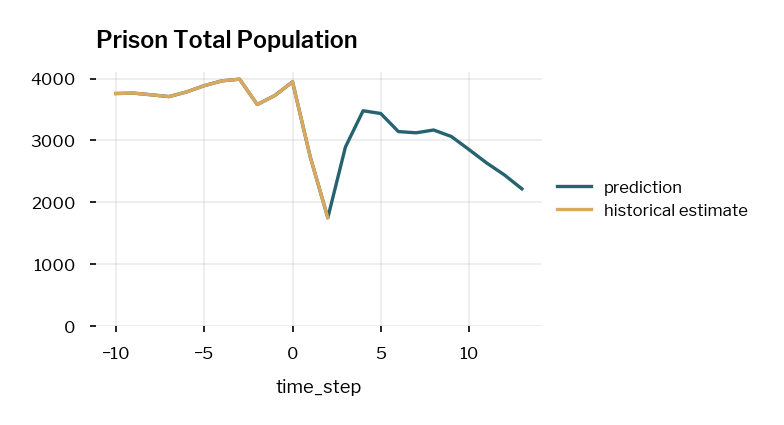

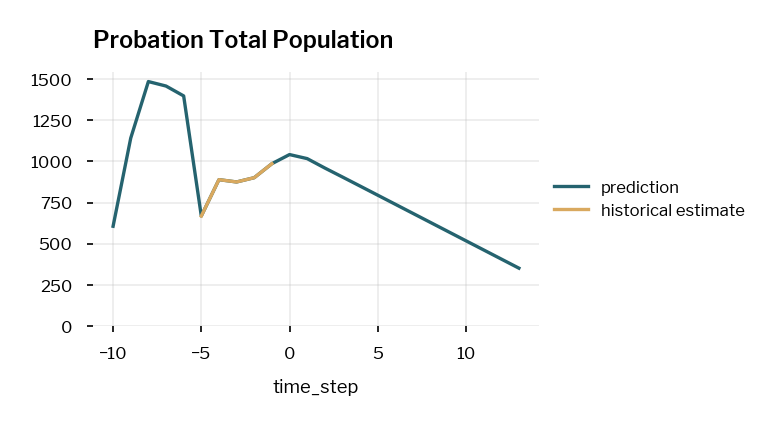

In [188]:
total_population = data_inputs.total_population_data

for compartment, df in baseline_projection.groupby("compartment"):
    if "release" in compartment:
        continue
    plt.figure()
    df.set_index(["time_step"])["total_population"].plot(label="prediction")

    compartment_pop = total_population[total_population["compartment"] == compartment]
    compartment_pop.groupby(["time_step"])["total_population"].sum().plot(
        label="historical estimate"
    )

    add_legend()
    plt.title(f"{compartment.title()} Total Population")
    plt.ylim([0, None])

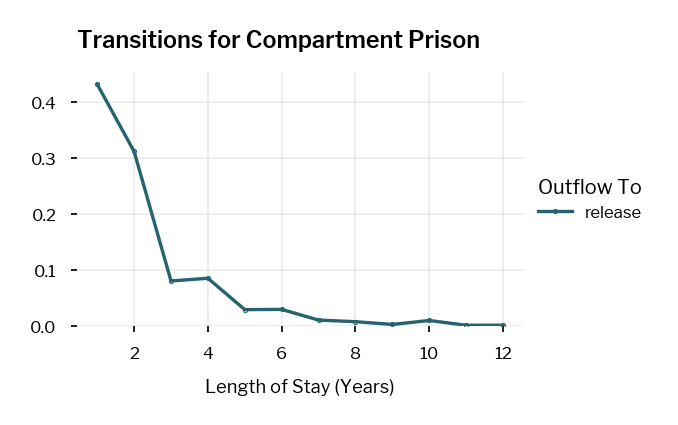

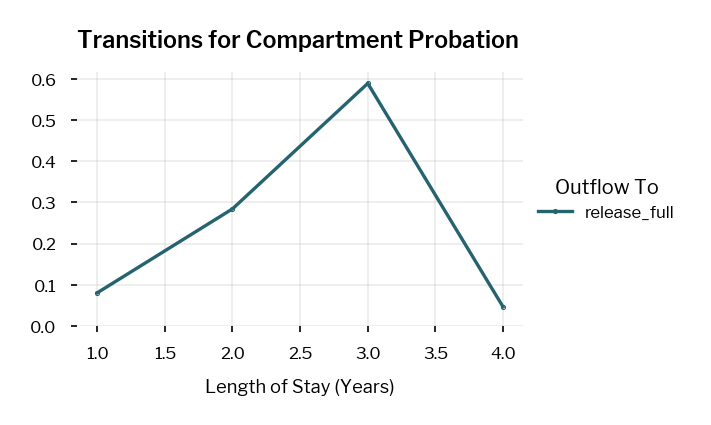

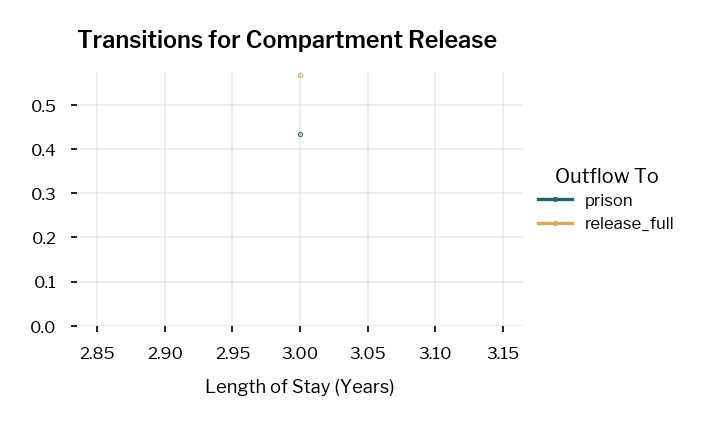

In [189]:
transitions = data_inputs.transitions_data
for compartment, df in transitions.groupby("compartment"):
    if compartment == "release_full":
        continue
    normalization_constant = sum(df["total_population"])
    (
        df.set_index(["compartment_duration", "outflow_to"])[
            "total_population"
        ].unstack("outflow_to")
        / normalization_constant
    ).plot(marker=".", markersize="0.5")
    plt.title(f"Transitions for Compartment {compartment.title()}")
    add_legend(title="Outflow To")
    plt.xlabel("Length of Stay (Years)")
    plt.ylim([0, None])

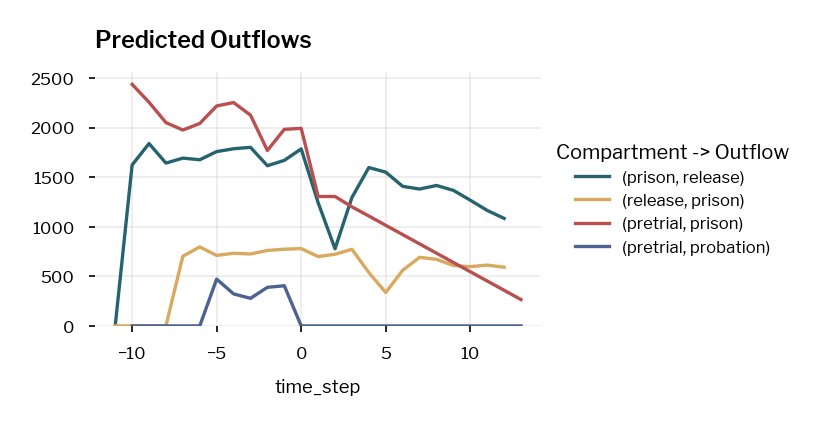

In [23]:
baseline_outflows[
    baseline_outflows.index.get_level_values("outflow_to") != "release_full"
].groupby(["time_step", "compartment", "outflow_to"])["total_population"].sum().unstack(
    ["compartment", "outflow_to"]
).plot(
    label="Projected"
)
plt.title(f"Predicted Outflows")
plt.ylim([0, None])
add_legend(title="Compartment -> Outflow")

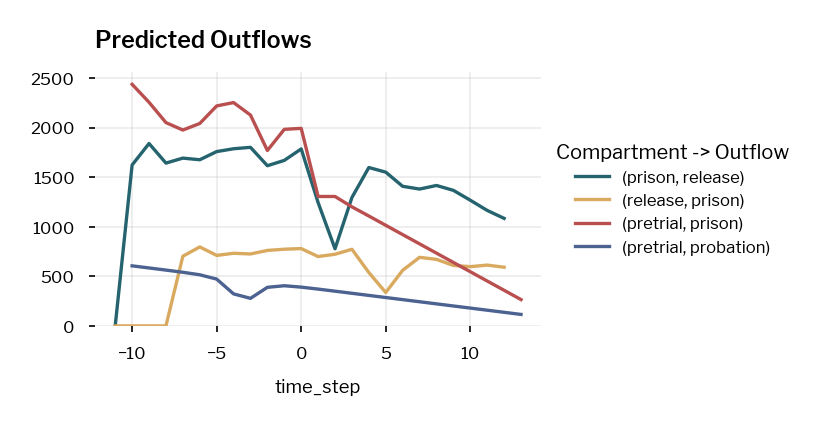

In [190]:
baseline_outflows[
    baseline_outflows.index.get_level_values("outflow_to") != "release_full"
].groupby(["time_step", "compartment", "outflow_to"])["total_population"].sum().unstack(
    ["compartment", "outflow_to"]
).plot(
    label="Projected"
)
plt.title(f"Predicted Outflows")
plt.ylim([0, None])
add_legend(title="Compartment -> Outflow")

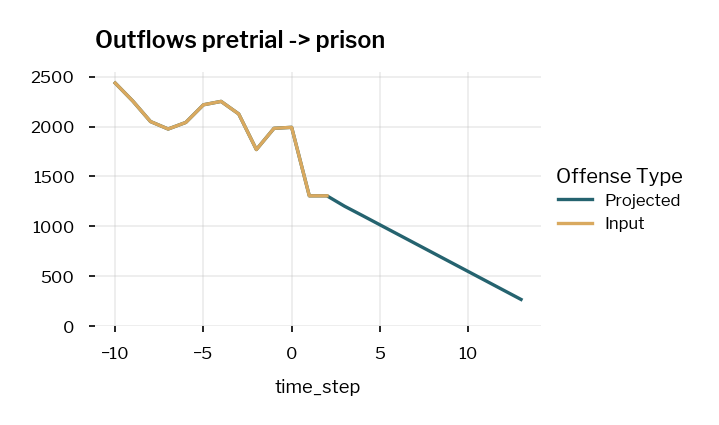

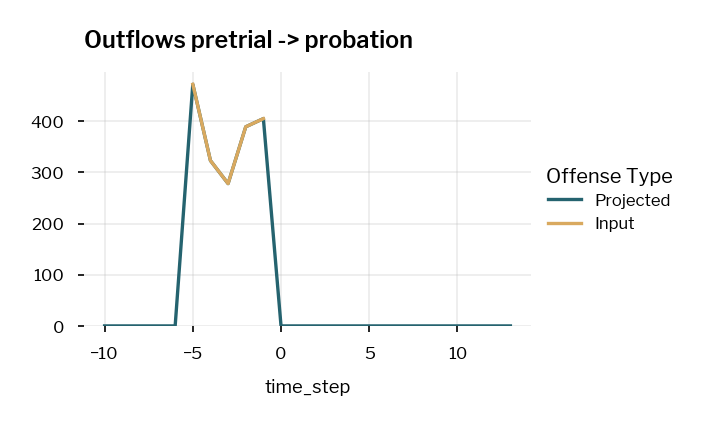

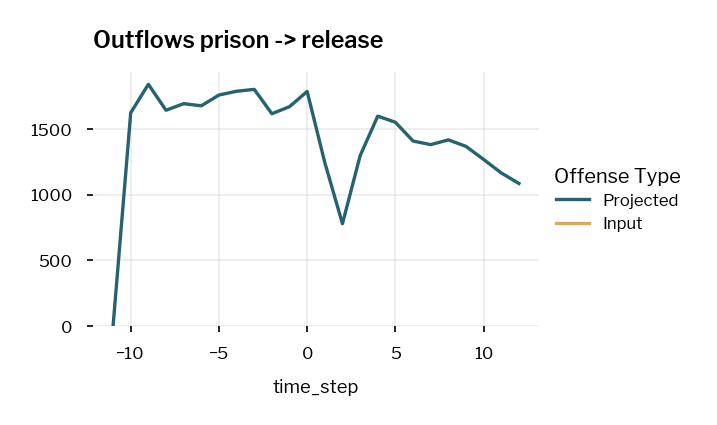

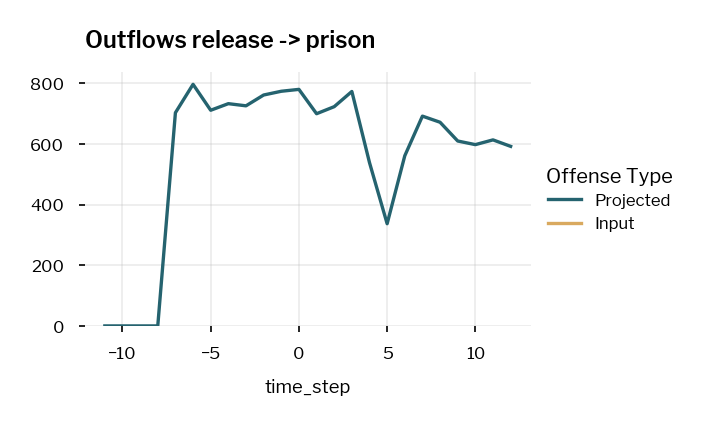

In [37]:
for (compartment, outflow_to), df in baseline_outflows.groupby(
    ["compartment", "outflow_to"]
):
    if outflow_to == "release_full":
        continue
    plt.figure()
    ax = df.reset_index("outflow_to")["total_population"].plot(label="Projected")

    historical_outflows = outflows[
        (outflows["compartment"] == compartment)
        & (outflows["outflow_to"] == outflow_to)
    ]
    historical_outflows.plot(x="time_step", y="total_population", ax=ax, label="Input")

    add_legend(title="Offense Type")
    plt.title(f"Outflows {compartment} -> {outflow_to}")
    plt.ylim([0, None])

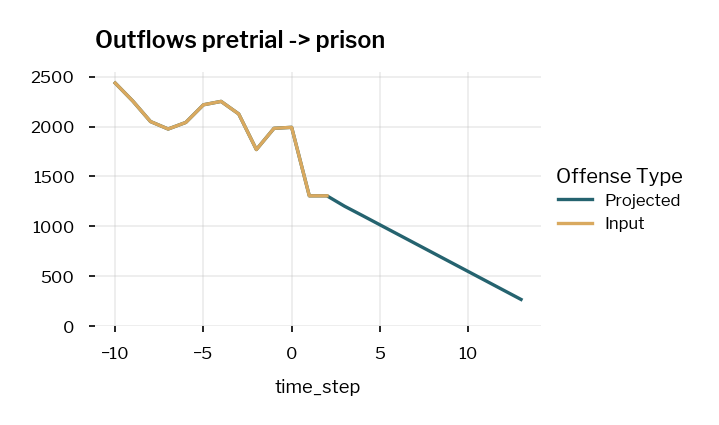

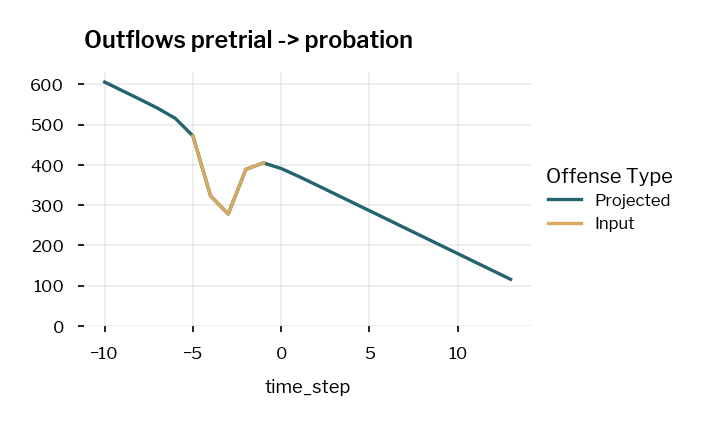

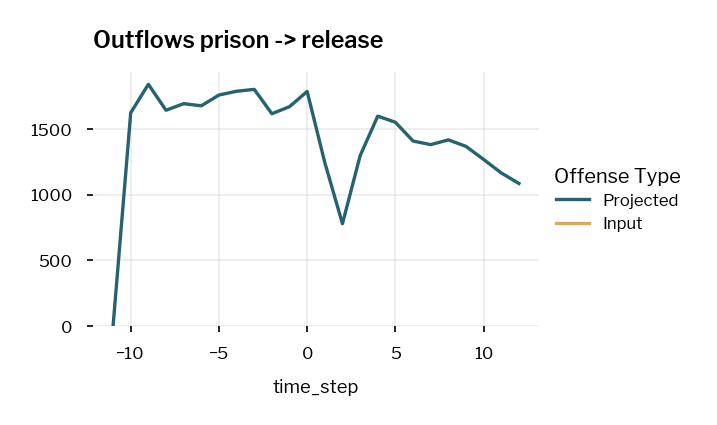

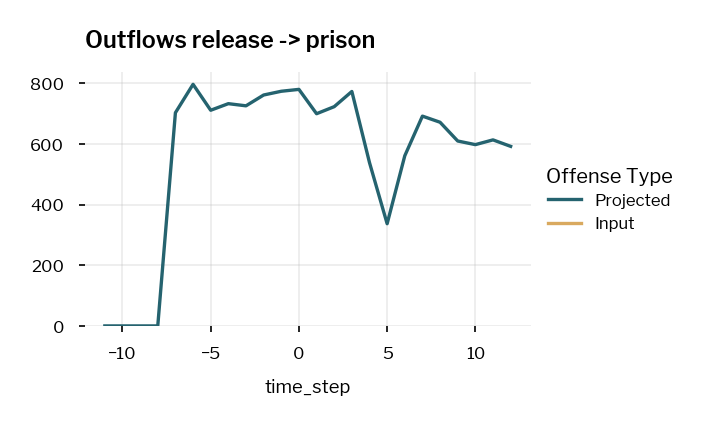

In [195]:
for (compartment, outflow_to), df in baseline_outflows.groupby(
    ["compartment", "outflow_to"]
):
    if outflow_to == "release_full":
        continue
    plt.figure()
    ax = df.reset_index("outflow_to")["total_population"].plot(label="Projected")

    historical_outflows = outflows[
        (outflows["compartment"] == compartment)
        & (outflows["outflow_to"] == outflow_to)
    ]
    historical_outflows.plot(x="time_step", y="total_population", ax=ax, label="Input")

    add_legend(title="Offense Type")
    plt.title(f"Outflows {compartment} -> {outflow_to}")
    plt.ylim([0, None])

In [76]:
predicted_outflows = policy_sim.simulator.pop_simulations[
    "baseline_projections"
].get_outflows()
predicted_outflows.groupby(["compartment", "outflow"])

total_population   compartment simulation_group
outflow_to   time_step                                                 
prison       -18             5045.941842      pretrial                x
             -17             4967.231427      pretrial                x
             -16             4887.825920      pretrial                x
             -15             4806.965459      pretrial                x
             -14             4723.059514      pretrial                x
...                                  ...           ...              ...
release_full  8            169973.234769  release_full                x
              9            183458.153217  release_full                x
              10           197445.314333  release_full                x
              11           212392.922519  release_full                x
              12           228227.369093  release_full                x

[224 rows x 3 columns]

In [145]:
policy_sim.get_population_simulations()["baseline_projections"]\
    .sub_simulations["x"].simulation_compartments["probation"]
    .compartment_transitions

policy_ts -9999
policy_ts -9999


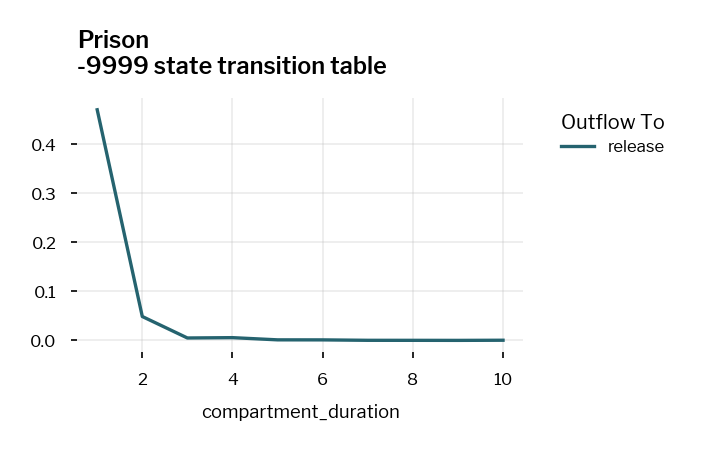

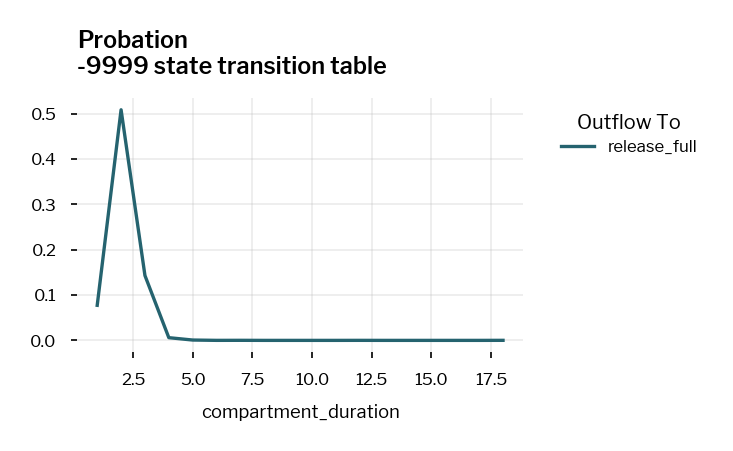

In [155]:
simulation_key = "baseline_projections"
for compartment in ["prison", "probation"]:
    for _, sub_sim in policy_sim.get_population_simulations()[
        simulation_key
    ].sub_simulations.items():
        spark_compartment = sub_sim.simulation_compartments[compartment]

        policy_ts = max(
            spark_compartment.compartment_transitions.transition_tables.keys()
        )
        print(f"policy_ts {policy_ts}")
        for (
            time_step,
            transition_df,
        ) in spark_compartment.compartment_transitions.transition_tables[
            policy_ts
        ].tables.items():

            unnormalized_table = TransitionTable._unnormalized_table(transition_df)

            #                 transition_df = pd.DataFrame((transition_df.drop(['remaining'], axis=1) * 100).stack('outflow_to'),
            #                                              columns=['transition_percent'])
            #                 transition_df['compartment'] = compartment
            #                 transition_df['time_step'] = time_step
            #                 transition_df = transition_df.set_index(['time_step', 'compartment'], append=True).reorder_levels(
            #                     ['time_step', 'compartment', 'compartment_duration', 'outflow_to']).unstack('outflow_to')

            title = f"{compartment.title()}\n{time_step} state transition table"
            unnormalized_table.plot(title=title)
            #                 ax_list = transition_df.loc[time_step, compartment].plot(
            #                     y='transition_percent', title=title, marker=".", markersize=0.5
            #                 )
            plt.legend(title="Outflow To", bbox_to_anchor=(1.05, 1), loc="upper left")